In [1]:
# install Yao/YaoPlots via 
#     using Pkg
#     Pkg.add("Yao")
#     Pkg.add("YaoPlots")

using Yao,YaoPlots,LinearAlgebra

# Quantum Fourier Transform 

shift gate $${\rm shift}(\theta) = \left(\begin{array}{cc} 1 & 0 \\ 0 & e^{i\theta} \end{array}\right)$$

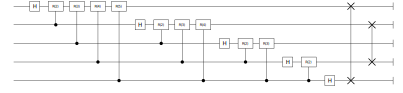

In [2]:
controlR(k) = control(k, 1=>label(shift(2π/2^k),"R($k)"))
qftblock(b) = chain(b, put(1=>H), chain(controlR(k) for k in 2:b))
qft(n) = chain(n, 
    chain(put(k:n => qftblock(n-k+1)) for k in 1:n),
    chain(swap(k,n-k+1) for k in Int.(1:(n/2)))
)

plot(qft(5))

# Phase Estimation

We define $U(i) = U^{2^i}$ as a composition of $2^i$ gates $U$

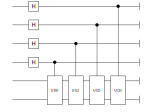

In [3]:
ublock(i,n,p,U) = chain(
    put(p-i=>H),
    control(p-i, p+1:p+n => label(matblock(U^(2^i)), "U($i)"))
)
ucircuit(n,p,U) = chain(n+p, ublock(i-1,n,p,U) for i in 1:p)
plot(ucircuit(2,4,rand_unitary(2^2)))

### Full Phase Estimation circuit

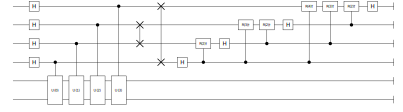

In [4]:
pecircuit(n,p,U) = chain(ucircuit(n,p,U), put(1:p => qft(p)'))
plot(pecircuit(2,4,rand_unitary(2^2)))

# Run the experiment

Construct a random $n$-qubit unitary matrix $U$ with eigenvalues $e^{2\pi i \frac{k}{2^{p}}}$ for integers $k$ and $p$. The precision $p$ refers to the number of bits necessary to describe the phase

In [7]:
p = 4
n = 2

eigenvalues = [rand(0:2^p-1) for k in 1:2^n]

4-element Vector{Int64}:
 15
 10
  0
  2

In [8]:
V = rand_unitary(2^n)
U = V*Diagonal(map(k-> exp(2π*1im*k/2^p), eigenvalues))*V'

4×4 Matrix{ComplexF64}:
    0.19203-0.429134im     0.169573-0.156469im   …   -0.502645+0.0956219im
   0.233272+0.00820405im   0.854775-0.0391563im     -0.0437506+0.254727im
   0.701454+0.254696im    -0.135611-0.121987im        0.442213+0.0418809im
 -0.0118975-0.409189im    0.0719627+0.41969im         0.551616+0.41209im

In [9]:
ψ = zero_state(n+p) |> pecircuit(n,p,U)

ArrayReg{1, ComplexF64, Array...}
    active qubits: 6/6

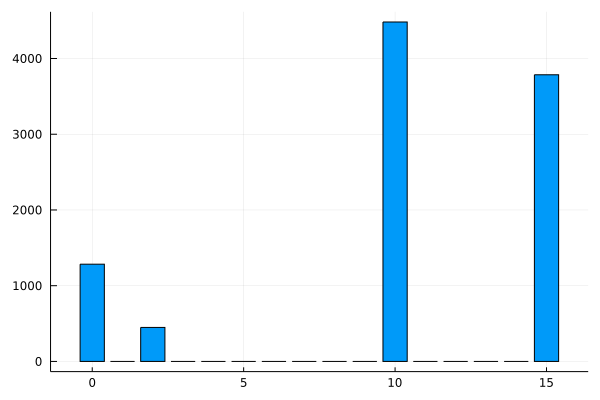

In [15]:
using Plots: bar

reversebits(x,p) = parse(Int,*(string.(digits(x; base=2,pad=p))...); base=2)

probs = measure(ψ,1:p,  nshots=10000)
counts = [(reversebits(i,p), count(==(i),Int.(probs))) for i=0:2^p-1]

bar(counts, legend=nothing)

In [11]:
sort(eigenvalues)

4-element Vector{Int64}:
  0
  2
 10
 15

The only possible outcomes are the eigenvalues of $U$